1-3Generalization

1-3-1 Can network fit random labels?


Epoch 001: train loss 2.3025 | test loss 2.3045
Epoch 002: train loss 2.3017 | test loss 2.3018
Epoch 003: train loss 2.3013 | test loss 2.3114
Epoch 004: train loss 2.3012 | test loss 2.3056
Epoch 005: train loss 2.3006 | test loss 2.3032
Epoch 006: train loss 2.3002 | test loss 2.3001
Epoch 007: train loss 2.2997 | test loss 2.3157
Epoch 008: train loss 2.2987 | test loss 2.3022
Epoch 009: train loss 2.2971 | test loss 2.3095
Epoch 010: train loss 2.2950 | test loss 2.3294
Epoch 011: train loss 2.2925 | test loss 2.3276
Epoch 012: train loss 2.2882 | test loss 2.3423
Epoch 013: train loss 2.2841 | test loss 2.3202
Epoch 014: train loss 2.2786 | test loss 2.3257
Epoch 015: train loss 2.2723 | test loss 2.3380
Epoch 016: train loss 2.2635 | test loss 2.3627
Epoch 017: train loss 2.2542 | test loss 2.3592
Epoch 018: train loss 2.2426 | test loss 2.3747
Epoch 019: train loss 2.2295 | test loss 2.4048
Epoch 020: train loss 2.2157 | test loss 2.4271
Epoch 021: train loss 2.2002 | test loss

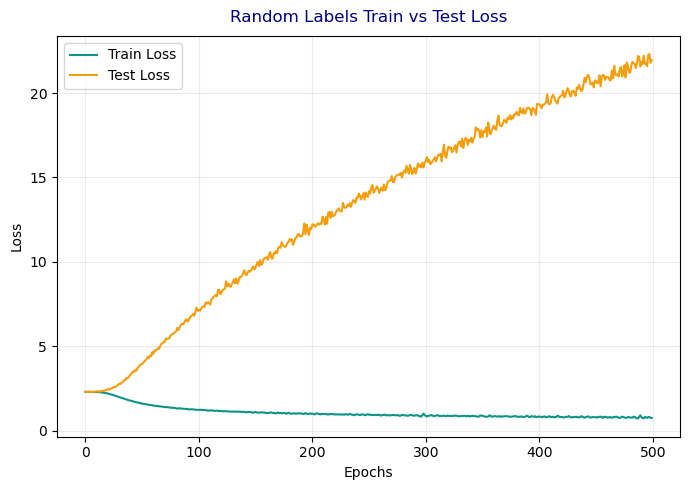

Saved figure to: hw1_3_1_ref/mnist_random_labels_train_vs_test_loss.png


In [1]:
import os, random, numpy as np
import torch, torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision, torchvision.transforms as T
from torch.optim import Adam
import matplotlib.pyplot as plt


SEED = 2025
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

OUTDIR = "hw1_3_1_ref"; os.makedirs(OUTDIR, exist_ok=True)
EPOCHS   = 500          
LR       = 1e-3
WEIGHT_DECAY = 0.0      
PRINT_EVERY = 1

tfm = T.Compose([T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])
train_base = torchvision.datasets.MNIST("./data", train=True,  download=True, transform=tfm)
test_ds    = torchvision.datasets.MNIST("./data", train=False, download=True, transform=tfm)


y = np.array(train_base.targets, dtype=np.int64)
perm = np.random.permutation(len(y))
train_base.targets = torch.tensor(y[perm], dtype=torch.long)

train_ld = DataLoader(train_base, batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)
test_ld  = DataLoader(test_ds,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)


class MLP256(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256), nn.ReLU(inplace=True),
            nn.Linear(256, 256),    nn.ReLU(inplace=True),
            nn.Linear(256, 256),    nn.ReLU(inplace=True),
            nn.Linear(256, 10)
        )
    def forward(self, x): return self.net(x)

model = MLP256().to(device)
opt = Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss()


@torch.no_grad()
def eval_epoch():
    model.eval()
    n, loss_sum = 0, 0.0
    for x, y in test_ld:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum += loss.item() * x.size(0)
        n += x.size(0)
    return loss_sum / n

def train_epoch():
    model.train()
    n, loss_sum = 0, 0.0
    for x, y in train_ld:
        x, y = x.to(device), y.to(device)
        opt.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        opt.step()
        loss_sum += loss.item() * x.size(0)
        n += x.size(0)
    return loss_sum / n

train_losses, test_losses = [], []
for ep in range(1, EPOCHS + 1):
    tr_loss = train_epoch()
    te_loss = eval_epoch()
    train_losses.append(tr_loss); test_losses.append(te_loss)
    if ep % PRINT_EVERY == 0:
        print(f"Epoch {ep:03d}: train loss {tr_loss:.4f} | test loss {te_loss:.4f}")


plt.figure(figsize=(7,5))
plt.title("Random Labels Train vs Test Loss", color="navy", pad=10)
plt.plot(train_losses, label="Train Loss", color="#0d9488")  # teal
plt.plot(test_losses,  label="Test Loss",  color="#f59e0b")  # orange
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
fig_path = os.path.join(OUTDIR, "mnist_random_labels_train_vs_test_loss.png")
plt.savefig(fig_path, dpi=150); plt.show()
print("Saved figure to:", fig_path)
